# Conversión de Datos MEG a CSV - LibriBrain Competition

Este notebook convierte los datos de MEG (archivos .h5) y eventos (archivos .tsv) del dataset LibriBrain en un formato CSV unificado, listo para machine learning.

## Funcionalidades:
- 🔄 Conversión de formato .h5 + .tsv → CSV unificado
- 📊 Análisis de sincronización entre datos MEG y eventos
- 🔧 Downsampling configurable para manejar el tamaño de datos
- 📈 Alineación temporal e interpolación de etiquetas
- 💾 Exportación en formatos normal y comprimido
- 📋 Estadísticas y visualizaciones del resultado

## Estructura del CSV resultante:
- **Columnas MEG**: Datos de sensores (306 canales por defecto)
- **Columna temporal**: Timestamp para cada muestra
- **Columnas de eventos**: Etiquetas interpoladas de los archivos .tsv
- **Metadatos**: Información de sesión y configuración

## 🎯 Cómo usar este notebook

### 📋 **Pasos para convertir tus datos:**

1. **Ejecuta las celdas en orden** (1 → 2 → 3 → 4 → 5 → 6 → 7)

2. **Modifica la configuración** en la celda 3:
   - Cambia `SELECTED_SESSION = "1"` por `"2"` para procesar la sesión 2
   - Los datos MEG se mantienen en valores originales sin modificaciones
   - Modifica rutas en `DATA_DIR` si tus datos están en otra ubicación

3. **Personaliza la exportación** en la celda 3:
   - Cambia `include_timestamps` para incluir/excluir columna temporal
   - Ajusta `export_compressed` para generar versión comprimida
   - Modifica `csv_precision` para precisión decimal

### 📊 **Estructura del CSV resultante:**

| Columna | Tipo | Descripción |
|---------|------|-------------|
| `timestamp` | float32 | Tiempo en segundos (opcional) |
| `MEG_ch_001` - `MEG_ch_306` | float64 | Señales MEG en valores originales por canal |
| `event_silence` | int8 | 1=Evento silencio activo, 0=inactivo |
| `event_word` | int8 | 1=Evento palabra activo, 0=inactivo |
| `event_phoneme` | int8 | 1=Evento fonema activo, 0=inactivo |
| `word_segment` | object | Palabra/segmento detectado (si aplica) |
| `value_*` | float32 | Valores numéricos interpolados de eventos |

### 🔧 **Configuraciones recomendadas:**

- **Datos originales**: Los valores MEG se mantienen exactamente como están en el archivo .h5
- **Sin escalado**: No se aplica ninguna multiplicación o transformación
- **Sin normalización**: Los datos conservan su escala y distribución original
- **Interpolación de eventos**: Solo se interpolan las etiquetas temporales, no los datos MEG

### 💡 **Próximos pasos:**

1. **Carga el CSV** en pandas: `df = pd.read_csv('Sherlock1_ses-1_meg_events_original.csv')`
2. **Separa características y etiquetas**: 
   ```python
   meg_cols = [col for col in df.columns if col.startswith('MEG_')]
   X = df[meg_cols].values  # Features MEG (valores originales)
   y = df['kind'].values  # Targets eventos
   ```
3. **Aplica tu propia normalización** si es necesaria para tu modelo específico
4. **Entrena tu modelo** con los datos en su forma original

¡Disfruta analizando tus datos de neurociencia normalizados! 🧠✨

In [32]:
# === CONFIGURACIÓN Y LIBRERÍAS ===

import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")

# === CONFIGURACIÓN PRINCIPAL ===

# Directorio base de datos
DATA_DIR = "../Data"

# Configuración de procesamiento
CONFIG = {
    'normalize_data': False,  # Datos originales sin modificaciones
    'normalization_method': None,  # Sin normalización
    'interpolation_method': 'linear',
    'export_compressed': True,
    'max_memory_gb': 4.0,
    'chunk_processing': True,
}

# Configuración de exportación
EXPORT_CONFIG = {
    'include_timestamps': True,  # ¿Incluir columna de tiempo?
    'include_metadata': True,   # ¿Incluir metadatos en archivo separado?
    'csv_precision': 6,         # Precisión decimal para CSV
    'compression': 'gzip',      # Tipo de compresión ('gzip', 'bz2', 'xz')
}

print("✅ Configuración cargada")
print(f"📁 Directorio de datos: {DATA_DIR}")
print(f"🔧 Datos: Sin modificaciones (valores originales)")
print(f"💾 Exportar comprimido: {CONFIG['export_compressed']}")

✅ Configuración cargada
📁 Directorio de datos: ../Data
🔧 Datos: Sin modificaciones (valores originales)
💾 Exportar comprimido: True


In [33]:
# === SELECCIÓN DE SESIONES Y VERIFICACIÓN ===

def find_available_sessions(data_dir):
    """Encuentra todas las sesiones disponibles en el directorio de datos"""
    sessions = {}
    
    if not os.path.exists(data_dir):
        print(f"❌ El directorio {data_dir} no existe")
        return sessions
    
    # Buscar en subdirectorios (Sherlock1, Sherlock2, etc.)
    for task_dir in os.listdir(data_dir):
        task_path = os.path.join(data_dir, task_dir)
        if not os.path.isdir(task_path):
            continue
            
        # Buscar archivos .h5 y .tsv
        h5_dir = os.path.join(task_path, "derivatives", "serialised")
        tsv_dir = os.path.join(task_path, "derivatives", "events")
        
        if os.path.exists(h5_dir) and os.path.exists(tsv_dir):
            h5_files = [f for f in os.listdir(h5_dir) if f.endswith('.h5')]
            tsv_files = [f for f in os.listdir(tsv_dir) if f.endswith('.tsv')]
            
            # Extraer números de sesión
            h5_sessions = set()
            tsv_sessions = set()
            
            for f in h5_files:
                if 'ses-' in f:
                    ses_num = f.split('ses-')[1].split('_')[0]
                    h5_sessions.add(ses_num)
            
            for f in tsv_files:
                if 'ses-' in f:
                    ses_num = f.split('ses-')[1].split('_')[0]
                    tsv_sessions.add(ses_num)
            
            # Solo incluir sesiones que tienen ambos archivos
            complete_sessions = h5_sessions.intersection(tsv_sessions)
            
            if complete_sessions:
                sessions[task_dir] = {
                    'sessions': sorted(list(complete_sessions)),
                    'h5_dir': h5_dir,
                    'tsv_dir': tsv_dir
                }
    
    return sessions

def verify_session_files(task, session, sessions_info):
    """Verifica que existan los archivos necesarios para una sesión"""
    if task not in sessions_info:
        return False, f"Task {task} no encontrada"
    
    if session not in sessions_info[task]['sessions']:
        return False, f"Sesión {session} no encontrada para {task}"
    
    # Construir nombres de archivos esperados
    h5_pattern = f"sub-0_ses-{session}_task-{task}_run-1_proc-bads+headpos+sss+notch+bp+ds_meg.h5"
    tsv_pattern = f"sub-0_ses-{session}_task-{task}_run-1_events.tsv"
    
    h5_path = os.path.join(sessions_info[task]['h5_dir'], h5_pattern)
    tsv_path = os.path.join(sessions_info[task]['tsv_dir'], tsv_pattern)
    
    if not os.path.exists(h5_path):
        return False, f"Archivo MEG no encontrado: {h5_path}"
    
    if not os.path.exists(tsv_path):
        return False, f"Archivo de eventos no encontrado: {tsv_path}"
    
    return True, (h5_path, tsv_path)

# Buscar sesiones disponibles
print("🔍 Buscando sesiones disponibles...")
available_sessions = find_available_sessions(DATA_DIR)

if not available_sessions:
    print("❌ No se encontraron sesiones válidas")
else:
    print("✅ Sesiones encontradas:")
    for task, info in available_sessions.items():
        print(f"  📁 {task}: {len(info['sessions'])} sesiones ({', '.join(info['sessions'])})")

# === SELECCIÓN DE SESIÓN A CONVERTIR ===
# Modifica estos valores para seleccionar la sesión a procesar
SELECTED_TASK = "Sherlock1"  # Cambia por: "Sherlock1", "Sherlock2", etc.
SELECTED_SESSION = "1"       # Cambia por el número de sesión deseado

# Verificar selección
if available_sessions:
    is_valid, result = verify_session_files(SELECTED_TASK, SELECTED_SESSION, available_sessions)
    
    if is_valid:
        h5_file_path, tsv_file_path = result
        print(f"\n✅ Sesión seleccionada: {SELECTED_TASK} - Sesión {SELECTED_SESSION}")
        print(f"📄 Archivo MEG: {os.path.basename(h5_file_path)}")
        print(f"📄 Archivo eventos: {os.path.basename(tsv_file_path)}")
        
        # Verificar tamaños de archivo
        h5_size = os.path.getsize(h5_file_path) / (1024**3)  # GB
        tsv_size = os.path.getsize(tsv_file_path) / (1024**2)  # MB
        
        print(f"💾 Tamaño MEG: {h5_size:.2f} GB")
        print(f"💾 Tamaño eventos: {tsv_size:.2f} MB")
        
        # Estimar tamaño del CSV resultante
        estimated_csv_size = h5_size * 1.5  # Estimación aproximada sin downsampling
        print(f"📊 Tamaño estimado CSV: {estimated_csv_size:.2f} GB")
        
    else:
        print(f"❌ Error: {result}")
        h5_file_path = tsv_file_path = None
else:
    h5_file_path = tsv_file_path = None

🔍 Buscando sesiones disponibles...
✅ Sesiones encontradas:
  📁 Sherlock1: 2 sesiones (1, 2)

✅ Sesión seleccionada: Sherlock1 - Sesión 1
📄 Archivo MEG: sub-0_ses-1_task-Sherlock1_run-1_proc-bads+headpos+sss+notch+bp+ds_meg.h5
📄 Archivo eventos: sub-0_ses-1_task-Sherlock1_run-1_events.tsv
💾 Tamaño MEG: 0.32 GB
💾 Tamaño eventos: 1.06 MB
📊 Tamaño estimado CSV: 0.48 GB


In [34]:
# === CARGA Y ANÁLISIS INICIAL DE DATOS ===

def load_meg_data(h5_file_path):
    """Carga datos MEG desde archivo .h5"""
    print("📥 Cargando datos MEG...")
    
    with h5py.File(h5_file_path, 'r') as f:
        # Cargar datos principales (generalmente en 'meg_data' o similar)
        data_keys = list(f.keys())
        
        # Buscar la clave de datos principal
        meg_data = None
        sfreq = None
        times = None
        ch_names = None
        
        # Intentar diferentes nombres comunes
        for key in ['meg_data', 'data', 'raw_data', 'signals']:
            if key in f:
                meg_data = f[key][:]
                print(f"✅ Datos MEG cargados: {meg_data.shape}")
                break
        
        # Intentar cargar metadatos
        if 'sfreq' in f:
            sfreq = f['sfreq'][()]
        elif 'sampling_frequency' in f:
            sfreq = f['sampling_frequency'][()]
        elif 'fs' in f:
            sfreq = f['fs'][()]
        else:
            # Si no encontramos sfreq, calcularlo desde times si está disponible
            if 'times' in f:
                times_data = f['times'][:]
                if len(times_data) > 1:
                    sfreq = 1.0 / (times_data[1] - times_data[0])
        
        if 'times' in f:
            times = f['times'][:]
        elif 'time' in f:
            times = f['time'][:]
        
        # Si aún no tenemos sfreq y tenemos times, calcularlo
        if sfreq is None and times is not None and len(times) > 1:
            sfreq = 1.0 / (times[1] - times[0])
        elif sfreq is None:
            # Valor por defecto basado en el dataset LibriBrain
            sfreq = 250.0  # Hz típico para MEG
            
        if 'ch_names' in f:
            ch_names = [name.decode() if isinstance(name, bytes) else name for name in f['ch_names'][:]]
        elif 'channel_names' in f:
            ch_names = [name.decode() if isinstance(name, bytes) else name for name in f['channel_names'][:]]
    
    # Si no encontramos datos, intentar con la primera clave disponible
    if meg_data is None and data_keys:
        with h5py.File(h5_file_path, 'r') as f:
            first_key = data_keys[0]
            if isinstance(f[first_key], h5py.Dataset):
                meg_data = f[first_key][:]
                print(f"⚠️ Usando datos de '{first_key}': {meg_data.shape}")
    
    return {
        'data': meg_data,
        'sfreq': sfreq,
        'times': times,
        'ch_names': ch_names,
        'n_channels': meg_data.shape[0] if meg_data is not None else None,
        'n_times': meg_data.shape[1] if meg_data is not None else None
    }

def load_events_data(tsv_file_path):
    """Carga datos de eventos desde archivo .tsv"""
    print("📥 Cargando datos de eventos...")
    
    events_df = pd.read_csv(tsv_file_path, sep='\t')
    print(f"✅ Eventos cargados: {events_df.shape}")
    
    # Detectar columna de tiempo (puede ser 'onset', 'timemeg', etc.)
    time_column = None
    possible_time_cols = ['onset', 'timemeg', 'time', 'timestamp']
    for col in possible_time_cols:
        if col in events_df.columns:
            time_column = col
            break
    
    if time_column is None:
        print("⚠️ No se encontró columna de tiempo reconocida")
        return events_df
    
    # Tipos de eventos - buscar diferentes nombres de columnas
    event_type_column = None
    possible_event_cols = ['trial_type', 'kind', 'event_type', 'type']
    for col in possible_event_cols:
        if col in events_df.columns:
            event_type_column = col
            break
    
    if event_type_column:
        event_counts = events_df[event_type_column].value_counts()
        print(f"🏷️ Tipos de eventos: {dict(event_counts)}")
    
    return events_df

# Cargar datos si tenemos archivos válidos
if h5_file_path and tsv_file_path:
    print("=" * 50)
    print("📂 CARGANDO DATOS")
    print("=" * 50)
    
    # Cargar datos MEG
    meg_info = load_meg_data(h5_file_path)
    
    # Cargar eventos
    events_df = load_events_data(tsv_file_path)
    
    print("\n" + "=" * 50)
    print("📊 RESUMEN FINAL")
    print("=" * 50)
    
    if meg_info['data'] is not None:
        duration_meg = meg_info['n_times'] / meg_info['sfreq']
        print(f"🧠 MEG: {meg_info['data'].shape} | {meg_info['sfreq']:.0f} Hz | {duration_meg:.0f}s")
        
        # Verificar sincronización temporal
        if meg_info['sfreq'] and not events_df.empty:
            time_column = None
            for col in ['onset', 'timemeg', 'time', 'timestamp']:
                if col in events_df.columns:
                    time_column = col
                    break
            
            if time_column:
                events_duration = events_df[time_column].max() - events_df[time_column].min()
                sync_status = "✅ Sincronizado" if abs(duration_meg - events_duration) < 10 else "⚠️ Desincronizado"
                print(f"📋 Eventos: {len(events_df)} eventos | {events_duration:.0f}s | {sync_status}")
    
    print("✅ Datos listos para procesamiento")
        
else:
    print("❌ No hay archivos válidos seleccionados")

📂 CARGANDO DATOS
📥 Cargando datos MEG...
✅ Datos MEG cargados: (306, 278000)
📥 Cargando datos de eventos...
✅ Eventos cargados: (12806, 12)
🏷️ Tipos de eventos: {'phoneme': np.int64(9592), 'word': np.int64(2836), 'silence': np.int64(378)}

📊 RESUMEN FINAL
🧠 MEG: (306, 278000) | 250 Hz | 1112s
📋 Eventos: 12806 eventos | 1070s | ⚠️ Desincronizado
✅ Datos listos para procesamiento


In [35]:
# === PROCESAMIENTO Y CONVERSIÓN ===

def normalize_meg_data(meg_data, method='zscore'):
    """Aplica normalización a los datos MEG"""
    print(f"🔄 Normalizando datos MEG ({method})...")
    normalized_data = meg_data.copy()
    if method == 'zscore':
        for i in range(meg_data.shape[0]):
            channel_data = meg_data[i, :]
            mean_val = np.mean(channel_data)
            std_val = np.std(channel_data)
            normalized_data[i, :] = (channel_data - mean_val) / std_val if std_val > 0 else channel_data - mean_val
    elif method == 'minmax':
        for i in range(meg_data.shape[0]):
            channel_data = meg_data[i, :]
            min_val = np.min(channel_data)
            max_val = np.max(channel_data)
            normalized_data[i, :] = (channel_data - min_val) / (max_val - min_val) if max_val > min_val else channel_data - min_val
    elif method == 'robust':
        for i in range(meg_data.shape[0]):
            channel_data = meg_data[i, :]
            median_val = np.median(channel_data)
            iqr = np.percentile(channel_data, 75) - np.percentile(channel_data, 25)
            normalized_data[i, :] = (channel_data - median_val) / iqr if iqr > 0 else channel_data - median_val
    print("✅ Normalización terminada.")
    return normalized_data

def create_time_vector(n_times, sfreq):
    if sfreq is None or sfreq <= 0:
        raise ValueError(f"Frecuencia de muestreo inválida: {sfreq}")
    return np.arange(n_times) / sfreq

def interpolate_kind_segment(events_df, meg_times, margin=0.01):
    """
    Interpola la columna 'kind' y 'segment' de los eventos sobre el vector temporal de MEG.
    - Añade un margen temporal a cada evento para capturar eventos cortos.
    - Prioriza la asignación word > phoneme > silence.
    """
    print(f"🔄 Interpolando 'kind' y 'segment' (mejorado)...")
    time_column = next((col for col in ['onset', 'timemeg', 'time', 'timestamp'] if col in events_df.columns), None)
    if time_column is None:
        print("❌ Sin columna de tiempo en eventos.")
        return pd.DataFrame({'kind': ['silence']*len(meg_times), 'segment': ['']*len(meg_times)})

    n_timepoints = len(meg_times)
    interpolated = pd.DataFrame({'kind': ['silence'] * n_timepoints, 'segment': [''] * n_timepoints})
    # Prioridad: word > phoneme > silence
    priority = {'word': 2, 'phoneme': 1, 'silence': 0}
    priorities = np.zeros(n_timepoints, dtype=int)

    for _, event in events_df.iterrows():
        onset = event[time_column]
        duration = event.get('duration', 0.1)
        # Añadir margen a ambos lados
        start = max(onset - margin, meg_times[0])
        end = min(onset + duration + margin, meg_times[-1])
        start_idx = np.searchsorted(meg_times, start, side='left')
        end_idx = np.searchsorted(meg_times, end, side='right')
        # Asegurar al menos una muestra
        if end_idx <= start_idx:
            end_idx = min(start_idx + 1, n_timepoints)
        # Determinar tipo de evento
        kind = str(event['kind']).strip().lower() if 'kind' in events_df.columns and pd.notna(event['kind']) else 'silence'
        segm = str(event['segment']).strip() if 'segment' in events_df.columns and pd.notna(event['segment']) else ''
        prio = priority.get(kind, 0)
        # Solo sobrescribir si la prioridad es mayor
        mask = (np.arange(n_timepoints) >= start_idx) & (np.arange(n_timepoints) < end_idx) & (prio > priorities)
        interpolated.loc[mask, 'kind'] = kind
        interpolated.loc[mask, 'segment'] = segm
        priorities[mask] = prio
    print(f"✅ Interpolación robusta completada.")
    return interpolated

def create_unified_dataframe_only_kind_segment(meg_data, meg_times, interpolated, ch_names=None):
    print("🔄 Unificando datos MEG + kind/segment...")
    meg_columns = [f"MEG_{name}" for name in ch_names] if ch_names and len(ch_names) == meg_data.shape[0] else [f"MEG_ch_{i:03d}" for i in range(meg_data.shape[0])]
    meg_df = pd.DataFrame(meg_data.T, columns=meg_columns)
    meg_df.insert(0, 'timestamp', meg_times)
    meg_df['kind'] = interpolated['kind'].values
    meg_df['segment'] = interpolated['segment'].values
    print(f"✅ DataFrame final: {meg_df.shape}")
    return meg_df

# Procesamiento principal
if meg_info['data'] is not None and not events_df.empty:
    print("=" * 40)
    print("🔄 PROCESANDO DATOS")
    print("=" * 40)
    
    # Usar los datos MEG originales sin ninguna modificación
    processed_meg = meg_info['data']  # Datos originales sin cambios
    print("✅ Usando datos MEG originales sin modificaciones.")
    
    processed_sfreq = meg_info['sfreq']
    meg_times = create_time_vector(processed_meg.shape[1], processed_sfreq)
    print(f"⏱️ {len(meg_times)} muestras, {processed_sfreq:.0f} Hz")
    interpolated = interpolate_kind_segment(events_df, meg_times)
    unified_df = create_unified_dataframe_only_kind_segment(processed_meg, meg_times, interpolated, meg_info['ch_names'])
    print(f"✅ Listo para exportar. Shape: {unified_df.shape}")
else:
    print("❌ No se pueden procesar los datos - faltan datos MEG o eventos")
    unified_df = None

🔄 PROCESANDO DATOS
✅ Usando datos MEG originales sin modificaciones.
⏱️ 278000 muestras, 250 Hz
🔄 Interpolando 'kind' y 'segment' (mejorado)...
✅ Interpolación robusta completada.
🔄 Unificando datos MEG + kind/segment...
✅ DataFrame final: (278000, 309)
✅ Listo para exportar. Shape: (278000, 309)
✅ Interpolación robusta completada.
🔄 Unificando datos MEG + kind/segment...
✅ DataFrame final: (278000, 309)
✅ Listo para exportar. Shape: (278000, 309)


In [36]:
display(unified_df)

timestamp    MEG_ch_000    MEG_ch_001    MEG_ch_002    MEG_ch_003  \
0          0.000000 -3.587435e-17  5.313981e-16  7.022026e-16 -4.277238e-17   
1          0.004000 -2.150946e-13  4.380218e-12  2.262359e-12 -2.902778e-13   
2          0.008000  9.243694e-14  2.120158e-12  3.793802e-12 -1.625074e-13   
3          0.012000 -1.022968e-13 -7.893710e-13  5.390671e-12 -3.504896e-13   
4          0.016000 -3.273526e-14  7.445615e-12  9.148931e-13 -2.502469e-13   
...             ...           ...           ...           ...           ...   
277995  1111.980068  4.989199e-12  3.131794e-10 -3.251174e-10  8.785258e-12   
277996  1111.984068  4.211232e-12  2.968578e-10 -3.040623e-10  7.988313e-12   
277997  1111.988068  5.147739e-12  3.196760e-10 -3.307959e-10  9.079923e-12   
277998  1111.992068  4.275509e-12  2.735120e-10 -2.824215e-10  7.595970e-12   
277999  1111.996068  5.145985e-12  3.435119e-10 -3.634487e-10  9.546517e-12   

          MEG_ch_004    MEG_ch_005    MEG_ch_006    MEG_ch_007    MEG_ch_008  \
0      -8.740993e-16 -8.053700e-16 -4.395400e-17  3.014402e-16  5.764744e-16   
1      -2.795012e-12  1.727566e-12 -1.668881e-13  1.053379e-13  4.802019e-12   
2       6.797623e-12 -2.299890e-12 -1.120765e-13  7.724833e-12  4.946557e-12   
3       7.289350e-12 -5.954921e-12 -3.623501e-13  7.549745e-12  3.924059e-12   
4       2.014483e-12  2.524107e-12 -1.068518e-13  9.065705e-12  5.204458e-12   
...              ...           ...           ...           ...           ...   
277995  8.585741e-11  1.495160e-10  7.955837e-12  2.406306e-10  3.881003e-12   
277996  6.754367e-11  1.439087e-10  7.275107e-12  2.162703e-10  3.461359e-12   
277997  8.535089e-11  1.540071e-10  8.151941e-12  2.437022e-10 -1.521060e-12   
277998  7.635587e-11  1.317216e-10  6.797693e-12  2.085193e-10 -1.891611e-13   
277999  9.320137e-11  1.645878e-10  8.538789e-12  2.649469e-10  8.531429e-14   

        ...    MEG_ch_298    MEG_ch_299    MEG_ch_300    MEG_ch_301  \
0       ... -2.926178e-15 -3.606087e-15  1.234592e-16  3.584508e-15   
1       ...  2.061893e-12  1.709424e-13 -4.848832e-13  7.134415e-12   
2       ...  7.666969e-12 -6.887109e-12 -7.607166e-13  1.093707e-11   
3       ...  1.273912e-11 -9.612208e-12 -7.450042e-13  1.814279e-11   
4       ...  1.072088e-11 -7.214664e-12 -7.449693e-13  1.474320e-11   
...     ...           ...           ...           ...           ...   
277995  ...  2.801828e-09  1.219551e-09 -9.412325e-11 -1.243487e-09   
277996  ...  2.594339e-09  1.130038e-09 -8.708727e-11 -1.160408e-09   
277997  ...  2.836988e-09  1.239125e-09 -9.494416e-11 -1.264385e-09   
277998  ...  2.451971e-09  1.065157e-09 -8.195657e-11 -1.094538e-09   
277999  ...  3.075997e-09  1.345028e-09 -1.030227e-10 -1.386726e-09   

          MEG_ch_302    MEG_ch_303    MEG_ch_304    MEG_ch_305     kind  \
0      -4.062282e-15  1.327608e-16  5.219779e-15  9.765123e-16  silence   
1       6.680093e-12  6.285648e-15 -1.538494e-11  4.430749e-12  silence   
2       2.011207e-12  5.600793e-14 -1.633860e-11  5.826541e-12  silence   
3       2.766186e-12  1.106955e-13 -1.890455e-11  1.262494e-11  silence   
4       6.367546e-13 -1.237149e-14 -1.131416e-11  1.468515e-11  silence   
...              ...           ...           ...           ...      ...   
277995  2.093632e-09 -4.454017e-11 -4.994113e-09  8.840937e-10  silence   
277996  1.939470e-09 -4.143743e-11 -4.616804e-09  8.218198e-10  silence   
277997  2.120271e-09 -4.486715e-11 -5.052499e-09  8.933550e-10  silence   
277998  1.829212e-09 -3.851648e-11 -4.370911e-09  7.661125e-10  silence   
277999  2.298410e-09 -4.848423e-11 -5.500717e-09  9.638617e-10  silence   

        segment  
0                
1                
2                
3                
4                
...         ...  
277995           
277996           
277997           
277998           
277999           

[278000 rows x 309 columns]

In [37]:
# === EXPORTACIÓN A CSV ===

def export_to_csv(df, base_filename, config):
    """Exporta DataFrame a CSV sin compresión"""
    # Usar valores por defecto si las claves no existen
    csv_precision = config.get('csv_precision', 6)
    
    # Exportación CSV normal
    csv_filename = f"{base_filename}.csv"
    print(f"💾 Exportando CSV: {csv_filename}")
    
    df.to_csv(
        csv_filename, 
        index=False, 
        float_format=f'%.{csv_precision}f'
    )
    
    csv_size = os.path.getsize(csv_filename) / (1024**3)  # GB
    print(f"  ✅ Guardado: {csv_size:.2f} GB")
    
    return {
        'filename': csv_filename,
        'size_gb': csv_size
    }

def create_metadata_file(base_filename, meg_info, events_df, config, export_config):
    """Crea archivo de metadatos con información del procesamiento"""
    metadata = {
        'processing_info': {
            'source_task': SELECTED_TASK,
            'source_session': SELECTED_SESSION,
            'normalize_data': False,
            'normalization_method': None,
            'data_modifications': 'None - Original values preserved',
            'interpolation_method': config.get('interpolation_method', 'linear'),
            'csv_precision': export_config.get('csv_precision', 6)
        },
        'meg_data': {
            'original_shape': list(meg_info['data'].shape) if meg_info['data'] is not None else None,
            'original_sfreq': meg_info['sfreq'],
            'processed_sfreq': meg_info['sfreq'],  # Sin downsampling, la frecuencia se mantiene
            'n_channels': meg_info['n_channels'],
            'channel_names': meg_info['ch_names'][:10] if meg_info['ch_names'] else None  # Primeros 10
        },
        'events_data': {
            'n_events': len(events_df),
            'event_types': events_df['kind'].unique().tolist() if 'kind' in events_df.columns else 
                          events_df['trial_type'].unique().tolist() if 'trial_type' in events_df.columns else [],
            'time_range': [float(events_df['timemeg'].min()), float(events_df['timemeg'].max())] if 'timemeg' in events_df.columns else
                         [float(events_df['onset'].min()), float(events_df['onset'].max())] if 'onset' in events_df.columns else []
        }
    }
    
    metadata_filename = f"{base_filename}_metadata.json"
    
    import json
    with open(metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=2, default=str)
    
    print(f"📋 Metadatos guardados: {metadata_filename}")
    return metadata_filename

# === EXPORTACIÓN PRINCIPAL ===
if unified_df is not None:
    print("=" * 60)
    print("💾 EXPORTANDO RESULTADOS")
    print("=" * 60)
    
    # Crear nombre base para archivos
    base_filename = f"{SELECTED_TASK}_ses-{SELECTED_SESSION}_meg_events_original"
    
    # Exportar CSV
    export_result = export_to_csv(unified_df, base_filename, EXPORT_CONFIG)
    
    # Crear metadatos si está habilitado
    if EXPORT_CONFIG.get('include_metadata', True):
        metadata_file = create_metadata_file(
            base_filename, meg_info, events_df, CONFIG, EXPORT_CONFIG
        )
    
    print("\n" + "=" * 60)
    print("✅ ARCHIVO CSV EXPORTADO")
    print("=" * 60)
    print(f"📁 Archivos generados:")
    print(f"  📄 CSV: {export_result['filename']} ({export_result['size_gb']:.2f} GB)")
    
    if EXPORT_CONFIG.get('include_metadata', True):
        print(f"  📋 Metadatos: {metadata_file}")
    
    print(f"\n🎯 Dataset listo para machine learning!")
    print(f"  📊 {unified_df.shape[0]} muestras × {unified_df.shape[1]} features")
    print(f"  🧠 {len([c for c in unified_df.columns if c.startswith('MEG_')])} canales MEG")
    print(f"  📋 {len([c for c in unified_df.columns if c.startswith('event_')])} tipos de eventos")
    
else:
    print("❌ No se puede exportar - fallo en el procesamiento")

💾 EXPORTANDO RESULTADOS
💾 Exportando CSV: Sherlock1_ses-1_meg_events_original.csv
  ✅ Guardado: 0.76 GB
📋 Metadatos guardados: Sherlock1_ses-1_meg_events_original_metadata.json

✅ ARCHIVO CSV EXPORTADO
📁 Archivos generados:
  📄 CSV: Sherlock1_ses-1_meg_events_original.csv (0.76 GB)
  📋 Metadatos: Sherlock1_ses-1_meg_events_original_metadata.json

🎯 Dataset listo para machine learning!
  📊 278000 muestras × 309 features
  🧠 306 canales MEG
  📋 0 tipos de eventos
  ✅ Guardado: 0.76 GB
📋 Metadatos guardados: Sherlock1_ses-1_meg_events_original_metadata.json

✅ ARCHIVO CSV EXPORTADO
📁 Archivos generados:
  📄 CSV: Sherlock1_ses-1_meg_events_original.csv (0.76 GB)
  📋 Metadatos: Sherlock1_ses-1_meg_events_original_metadata.json

🎯 Dataset listo para machine learning!
  📊 278000 muestras × 309 features
  🧠 306 canales MEG
  📋 0 tipos de eventos


📊 Categorías en 'kind': {'word': 199057, 'silence': 78943}
📏 Datos totales a visualizar: 278000 muestras
🔍 Períodos de habla encontrados: 199057
🔍 Períodos de silencio encontrados: 78943


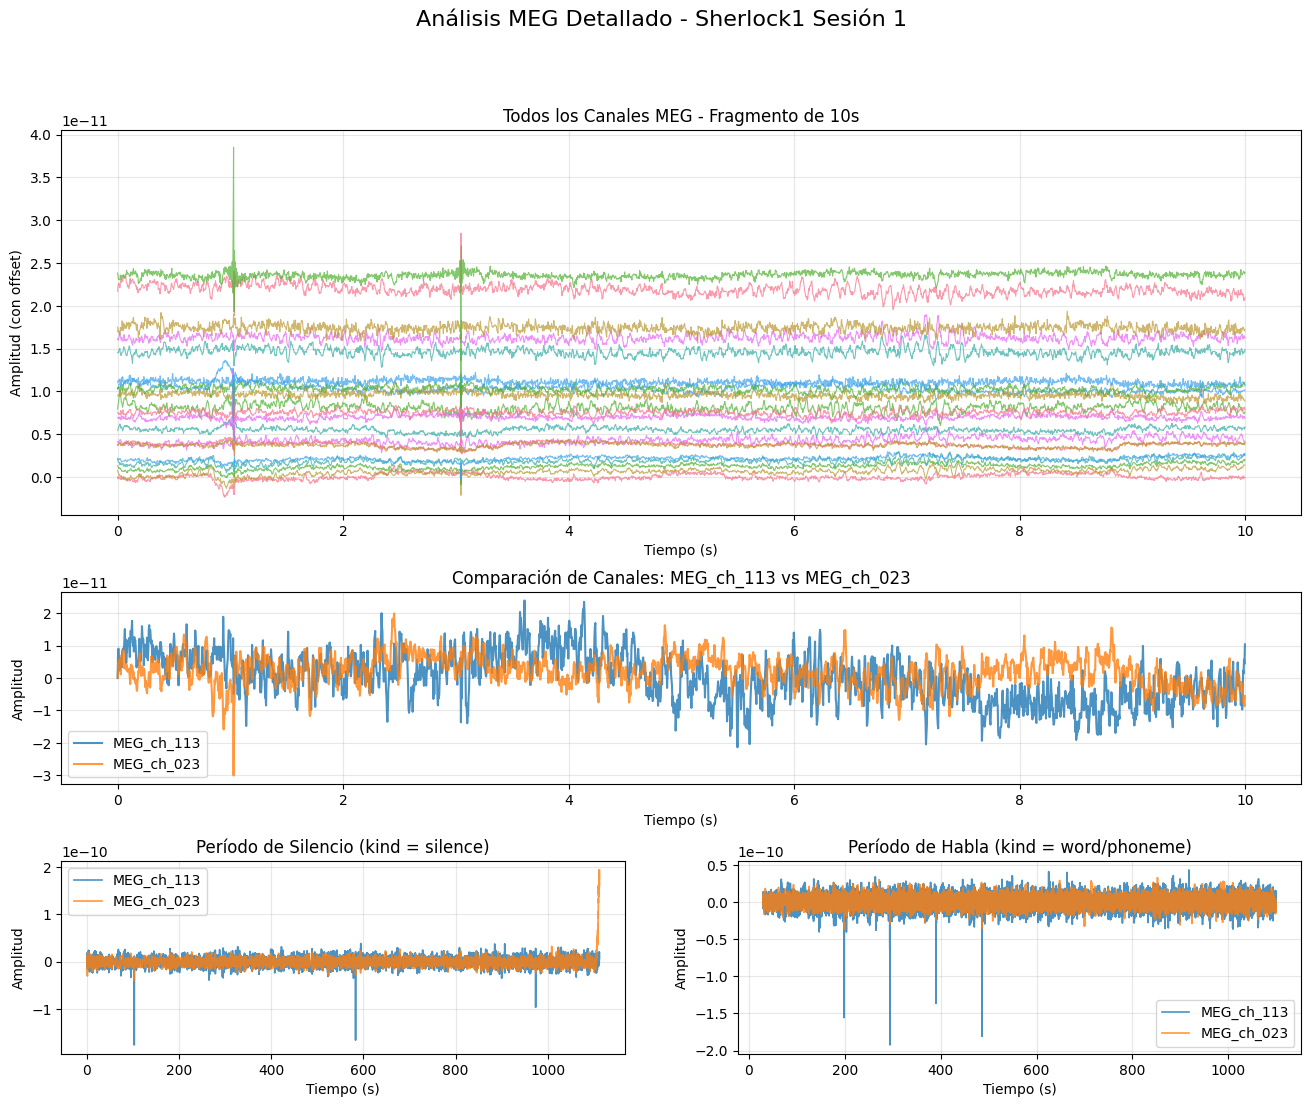


📊 Verificación de contadores:
  Total de muestras: 278,000
  Muestras de habla (word + phoneme): 199,057
  Muestras de silencio: 78,943
  Suma habla + silencio: 278,000
  Distribución real en 'kind': {'word': 199057, 'silence': 78943}


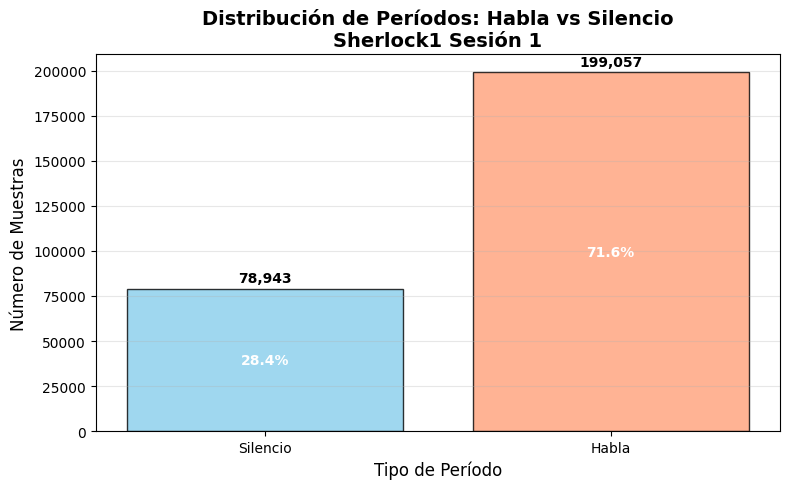

In [38]:
# === ANÁLISIS Y VISUALIZACIONES AVANZADAS ===

# Configuración de visualización
VISUALIZATION_CONFIG = {
    'time_window_seconds': 10,  # Ventana de tiempo a visualizar
    'selected_channels': ['MEG_0113', 'MEG_0023'],  # Canales a comparar (ajustar según tus datos)
    'figsize': (16, 12)
}

def create_meg_visualization(df):
    """
    Crea visualizaciones especializadas de datos MEG
    """
    if df is None or df.empty:
        print("❌ No hay datos para visualizar")
        return
    
    # Obtener configuración
    time_window = VISUALIZATION_CONFIG['time_window_seconds']
    selected_channels = VISUALIZATION_CONFIG['selected_channels']
    figsize = VISUALIZATION_CONFIG['figsize']
    
    # Preparar datos
    meg_cols = [col for col in df.columns if col.startswith('MEG_')]
    time_col = 'timestamp' if 'timestamp' in df.columns else 'time'
    
    if not meg_cols or time_col not in df.columns:
        print("❌ No se encontraron datos MEG o columna de tiempo")
        return
    
    # Unificar nombres de canal: permitir ambos formatos
    def normalize_channel_name(name):
        # Si es MEG_XXXX, convertir a MEG_ch_XXX si posible
        if name.startswith('MEG_') and name[4:].isdigit() and len(name[4:]) == 4:
            return f"MEG_ch_{int(name[4:]):03d}"
        return name
    
    # Ajustar canales seleccionados si no existen
    available_channels = [ch for ch in selected_channels if ch in meg_cols]
    if not available_channels:
        # Intentar normalizar nombres
        normalized_selected = [normalize_channel_name(ch) for ch in selected_channels]
        available_channels = [ch for ch in normalized_selected if ch in meg_cols]
    if not available_channels:
        available_channels = meg_cols[:2]  # Usar los primeros 2 canales disponibles
    
    # Usar todo el DataFrame en lugar de solo un fragmento
    df_fragment = df.copy()
    
    if df_fragment.empty:
        print("❌ No hay datos para visualizar")
        return
    
    # Verificar categorías de 'kind' disponibles en todo el DataFrame
    kind_vals = df_fragment['kind'].astype(str).str.lower()
    print(f"📊 Categorías en 'kind': {kind_vals.value_counts().to_dict()}")
    print(f"📏 Datos totales a visualizar: {len(df_fragment)} muestras")
    
    # Para las gráficas 1 y 2, usar solo un fragmento de tiempo para mejor visualización
    time_mask = df[time_col] <= df[time_col].min() + time_window
    df_time_fragment = df[time_mask].copy()
    
    # Crear figura con 3 subplots
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.2)
    
    # === GRÁFICA 1: TODOS LOS CANALES (ocupa todo el ancho) ===
    ax1 = fig.add_subplot(gs[0, :])
    channels_to_plot = meg_cols[::max(1, len(meg_cols)//20)]  # Subsamplear canales
    for i, channel in enumerate(channels_to_plot):
        offset = i * 2 * df_time_fragment[channel].std()
        ax1.plot(df_time_fragment[time_col], 
                df_time_fragment[channel] + offset, 
                linewidth=0.8, alpha=0.7, label=channel if i < 5 else "")
    ax1.set_xlabel('Tiempo (s)')
    ax1.set_ylabel('Amplitud (con offset)')
    ax1.set_title(f'Todos los Canales MEG - Fragmento de {time_window}s')
    ax1.grid(True, alpha=0.3)
    if len(channels_to_plot) <= 5:
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # === GRÁFICA 2: COMPARACIÓN DE 2 CANALES ===
    ax2 = fig.add_subplot(gs[1, :])
    for i, channel in enumerate(available_channels[:2]):
        ax2.plot(df_time_fragment[time_col], 
                df_time_fragment[channel], 
                linewidth=1.5, alpha=0.8, 
                label=f'{channel}',
                color=plt.cm.tab10(i))
    ax2.set_xlabel('Tiempo (s)')
    ax2.set_ylabel('Amplitud')
    ax2.set_title(f'Comparación de Canales: {" vs ".join(available_channels[:2])}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # === GRÁFICA 3: COMPARACIÓN DE 2 CANALES EN SILENCIO Y HABLA SEGÚN 'kind' ===
    ax3_left = fig.add_subplot(gs[2, 0])
    ax3_right = fig.add_subplot(gs[2, 1])
    
    # Filtrar períodos de habla y silencio usando la columna 'kind' (insensible a mayúsculas)
    kind_vals = df_fragment['kind'].astype(str).str.lower()
    habla_mask = kind_vals.isin(['word', 'phoneme'])
    silencio_mask = kind_vals == 'silence'
    
    print(f"🔍 Períodos de habla encontrados: {habla_mask.sum()}")
    print(f"🔍 Períodos de silencio encontrados: {silencio_mask.sum()}")
    
    # Gráfica izquierda: Período de silencio
    if silencio_mask.sum() > 0:
        for i, channel in enumerate(available_channels[:2]):
            ax3_left.plot(df_fragment.loc[silencio_mask, time_col],
                          df_fragment.loc[silencio_mask, channel],
                          linewidth=1.2, alpha=0.8,
                          label=f'{channel}',
                          color=plt.cm.tab10(i))
        ax3_left.set_title('Período de Silencio (kind = silence)')
        ax3_left.set_xlabel('Tiempo (s)')
        ax3_left.set_ylabel('Amplitud')
        ax3_left.legend()
        ax3_left.grid(True, alpha=0.3)
    else:
        ax3_left.text(0.5, 0.5, 'No hay períodos\nde silencio detectados',
                      ha='center', va='center', transform=ax3_left.transAxes)
        ax3_left.set_title('Período de Silencio')
    
    # Gráfica derecha: Período de habla
    if habla_mask.sum() > 0:
        for i, channel in enumerate(available_channels[:2]):
            ax3_right.plot(df_fragment.loc[habla_mask, time_col],
                           df_fragment.loc[habla_mask, channel],
                           linewidth=1.2, alpha=0.8,
                           label=f'{channel}',
                           color=plt.cm.tab10(i))
        ax3_right.set_title('Período de Habla (kind = word/phoneme)')
        ax3_right.set_xlabel('Tiempo (s)')
        ax3_right.set_ylabel('Amplitud')
        ax3_right.legend()
        ax3_right.grid(True, alpha=0.3)
    else:
        ax3_right.text(0.5, 0.5, 'No hay períodos\nde habla detectados',
                       ha='center', va='center', transform=ax3_right.transAxes)
        ax3_right.set_title('Período de Habla')
    
    plt.suptitle(f'Análisis MEG Detallado - {SELECTED_TASK} Sesión {SELECTED_SESSION}', 
                fontsize=16, y=0.98)
    plt.show()
    
    # === GRÁFICA ADICIONAL: CONTEOS DE HABLA Y SILENCIO ===
    fig_bar, ax_bar = plt.subplots(figsize=(8, 5))
    
    # Verificar y contar períodos correctamente
    total_samples = len(df_fragment)
    habla_count = habla_mask.sum()
    silencio_count = silencio_mask.sum()
    
    # Debug: mostrar detalles de los contadores
    print(f"\n📊 Verificación de contadores:")
    print(f"  Total de muestras: {total_samples:,}")
    print(f"  Muestras de habla (word + phoneme): {habla_count:,}")
    print(f"  Muestras de silencio: {silencio_count:,}")
    print(f"  Suma habla + silencio: {habla_count + silencio_count:,}")
    
    # Verificar distribución real en los datos
    print(f"  Distribución real en 'kind': {kind_vals.value_counts().to_dict()}")
    
    # Solo usar Silencio y Habla (sin "Otros")
    categories = ['Silencio', 'Habla']
    counts = [silencio_count, habla_count]
    colors = ['#87CEEB', '#FFA07A']  # Azul claro, Salmón
    
    bars = ax_bar.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black')
    
    # Añadir etiquetas con los valores en las barras
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax_bar.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
                    f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    ax_bar.set_title(f'Distribución de Períodos: Habla vs Silencio\n{SELECTED_TASK} Sesión {SELECTED_SESSION}', 
                     fontsize=14, fontweight='bold')
    ax_bar.set_ylabel('Número de Muestras', fontsize=12)
    ax_bar.set_xlabel('Tipo de Período', fontsize=12)
    ax_bar.grid(True, alpha=0.3, axis='y')
    
    # Añadir porcentajes (calculados sobre el total de muestras analizadas)
    for i, (bar, count) in enumerate(zip(bars, counts)):
        height = bar.get_height()
        percentage = (count / total_samples) * 100 if total_samples > 0 else 0
        ax_bar.text(bar.get_x() + bar.get_width()/2., height/2,
                    f'{percentage:.1f}%', ha='center', va='center', 
                    fontweight='bold', color='white' if percentage > 10 else 'black')
    
    plt.tight_layout()
    plt.show()

# === EJECUTAR ANÁLISIS ===
if unified_df is not None:
    create_meg_visualization(unified_df)
else:
    print("❌ No se puede generar análisis - DataFrame no disponible")

🔬 Iniciando análisis espectral avanzado...
📊 Configuración del análisis:
   Frecuencia de muestreo: 249.99998474121094 Hz
   Duración mínima de segmento: 0.5s (124 muestras)
   Rango de frecuencias: (0.5, 100) Hz
📡 Canales de habla encontrados: 23
🔍 Detectando segmentos continuos de habla y silencio...
  📈 Segmentos de habla detectados: 512
  📉 Segmentos de silencio detectados: 226
  📊 Duración promedio habla: 370.8 muestras
  📊 Duración promedio silencio: 279.2 muestras

🔄 Procesando segmentos por canal...
  📈 Analizando canal MEG_ch_018...
  📈 Analizando canal MEG_ch_020...
  📈 Analizando canal MEG_ch_022...
  📈 Analizando canal MEG_ch_023...
  📈 Analizando canal MEG_ch_045...
  📈 Analizando canal MEG_ch_120...
  📈 Analizando canal MEG_ch_138...
  📈 Analizando canal MEG_ch_140...
  📈 Analizando canal MEG_ch_142...
  📈 Analizando canal MEG_ch_045...
  📈 Analizando canal MEG_ch_120...
  📈 Analizando canal MEG_ch_138...
  📈 Analizando canal MEG_ch_140...
  📈 Analizando canal MEG_ch_142.

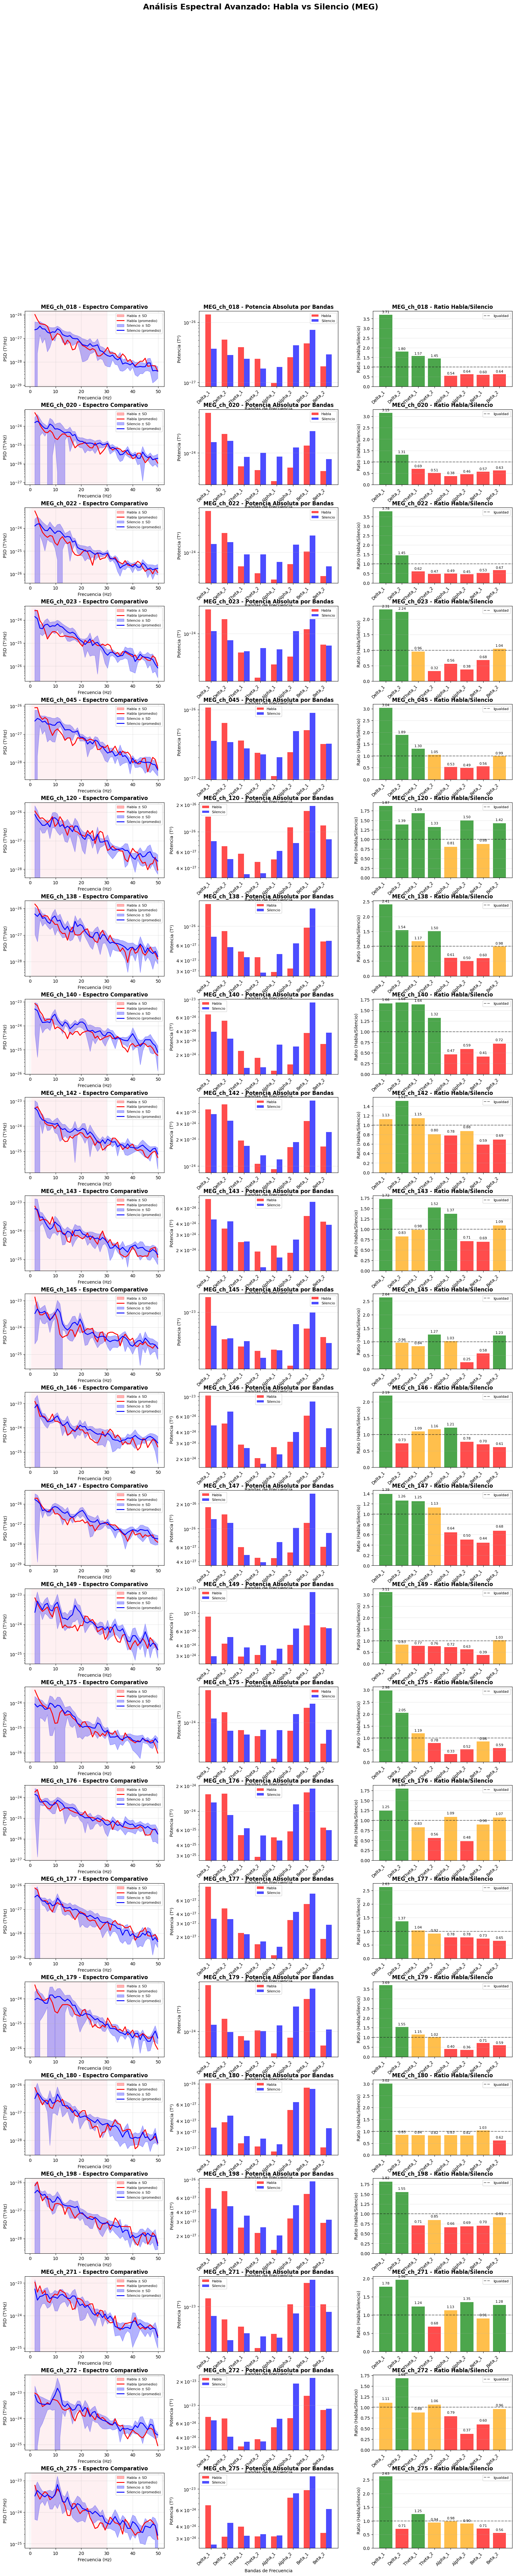


💾 Resultados guardados en: Sherlock1_ses-1_spectral_analysis_results.json

✅ Análisis espectral avanzado completado exitosamente


In [39]:
# === ANÁLISIS ESPECTRAL AVANZADO: COMPARACIÓN HABLA VS SILENCIO ===

from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal import welch, spectrogram
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configuración mejorada para análisis espectral
# Dividir cada banda en dos sub-bandas
SPECTRAL_CONFIG = {
    'freq_range': (0.5, 100),     # Rango extendido hasta 100 Hz
    'freq_range_focus': (1, 50),  # Rango enfocado para visualización principal
    'nperseg_short': 256,         # Para segmentos cortos (mejor resolución temporal)
    'nperseg_long': 1024,         # Para segmentos largos (mejor resolución frecuencial)
    'overlap_ratio': 0.75,        # Mayor solapamiento para mejor estimación
    'window': 'hann',             # Ventana Hann para mejor supresión de lóbulos laterales
    'freq_bands': {               # Bandas cerebrales estándar (sin gamma)
        'Delta_1': (0.5, 2.25),
        'Delta_2': (2.25, 4),
        'Theta_1': (4, 6),
        'Theta_2': (6, 8),
        'Alpha_1': (8, 10.5),
        'Alpha_2': (10.5, 13),
        'Beta_1': (13, 21.5),
        'Beta_2': (21.5, 30)
    },
    'figsize': (20, 16),
    'min_segment_duration': 0.5,  # Mínimo 0.5s para análisis espectral confiable
    'spectral_methods': ['welch', 'multitaper'],  # Métodos espectrales a comparar
    'save_intermediate_results': True  # Guardar resultados intermedios
}

# Canales específicos para análisis de habla (basados en literatura MEG)
SENSORS_SPEECH_MASK = [18, 20, 22, 23, 45, 120, 138, 140, 142, 143, 145, 146, 147, 149, 175, 176, 177, 179, 180, 198, 271, 272, 275]

def calculate_power_spectral_density(data, sfreq, method='welch', freq_range=(0.5, 100), nperseg=1024):
    """
    Calcula la densidad espectral de potencia usando diferentes métodos
    """
    if len(data) < nperseg:
        nperseg = max(len(data) // 4, 64)  # Ajustar nperseg para datos cortos
    
    if method == 'welch':
        freqs, psd = signal.welch(
            data, fs=sfreq, nperseg=nperseg,
            noverlap=int(nperseg * SPECTRAL_CONFIG['overlap_ratio']),
            window=SPECTRAL_CONFIG['window'],
            scaling='density'
        )
    elif method == 'multitaper':
        try:
            from spectrum import pmtm
            psd, freqs = pmtm(data, NW=2.5, k=4, NFFT=nperseg, Fs=sfreq)
            freqs = np.linspace(0, sfreq/2, len(psd))
        except ImportError:
            # Fallback to Welch if spectrum package not available
            freqs, psd = signal.welch(
                data, fs=sfreq, nperseg=nperseg,
                noverlap=int(nperseg * SPECTRAL_CONFIG['overlap_ratio']),
                window=SPECTRAL_CONFIG['window']
            )
    
    # Filtrar rango de frecuencias
    freq_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    return freqs[freq_mask], psd[freq_mask]

def calculate_band_power(freqs, psd, band_range):
    """
    Calcula la potencia en una banda de frecuencia específica usando integración trapezoidal
    """
    band_mask = (freqs >= band_range[0]) & (freqs <= band_range[1])
    if np.sum(band_mask) == 0:
        return 0
    return np.trapz(psd[band_mask], freqs[band_mask])

def calculate_relative_band_power(freqs, psd, band_range, total_range=(0.5, 100)):
    """
    Calcula la potencia relativa en una banda respecto al total
    """
    band_power = calculate_band_power(freqs, psd, band_range)
    total_power = calculate_band_power(freqs, psd, total_range)
    return (band_power / total_power) * 100 if total_power > 0 else 0

def detect_speech_silence_segments(df, min_duration_samples):
    """
    Detecta segmentos continuos de habla y silencio con duración mínima
    """
    print("🔍 Detectando segmentos continuos de habla y silencio...")
    
    # Crear máscaras básicas
    habla_mask = (df['kind'] == 'word') | (df['kind'] == 'phoneme')
    silencio_mask = df['kind'] == 'silence'
    
    # Encontrar segmentos continuos
    def find_continuous_segments(mask, min_duration):
        segments = []
        in_segment = False
        start_idx = 0
        
        for i, is_active in enumerate(mask):
            if is_active and not in_segment:
                start_idx = i
                in_segment = True
            elif not is_active and in_segment:
                if i - start_idx >= min_duration:
                    segments.append((start_idx, i))
                in_segment = False
        
        # Verificar último segmento
        if in_segment and len(mask) - start_idx >= min_duration:
            segments.append((start_idx, len(mask)))
        
        return segments
    
    habla_segments = find_continuous_segments(habla_mask, min_duration_samples)
    silencio_segments = find_continuous_segments(silencio_mask, min_duration_samples)
    
    print(f"  📈 Segmentos de habla detectados: {len(habla_segments)}")
    print(f"  📉 Segmentos de silencio detectados: {len(silencio_segments)}")
    
    # Calcular estadísticas de duración
    if habla_segments:
        habla_durations = [(end - start) for start, end in habla_segments]
        print(f"  📊 Duración promedio habla: {np.mean(habla_durations):.1f} muestras")
    
    if silencio_segments:
        silencio_durations = [(end - start) for start, end in silencio_segments]
        print(f"  📊 Duración promedio silencio: {np.mean(silencio_durations):.1f} muestras")
    
    return habla_segments, silencio_segments

def create_advanced_spectral_analysis(df):
    """
    Análisis espectral avanzado comparando períodos de habla vs silencio con múltiples métricas
    """
    if df is None or df.empty:
        print("❌ No hay datos para análisis espectral")
        return
    
    print("🔬 Iniciando análisis espectral avanzado...")
    
    # Preparar datos
    meg_cols = [col for col in df.columns if col.startswith('MEG_')]
    sfreq = processed_sfreq
    min_duration_samples = int(SPECTRAL_CONFIG['min_segment_duration'] * sfreq)
    
    print(f"📊 Configuración del análisis:")
    print(f"   Frecuencia de muestreo: {sfreq} Hz")
    print(f"   Duración mínima de segmento: {SPECTRAL_CONFIG['min_segment_duration']}s ({min_duration_samples} muestras)")
    print(f"   Rango de frecuencias: {SPECTRAL_CONFIG['freq_range']} Hz")
    
    # Seleccionar canales específicos para habla
    selected_channels = []
    for sensor_idx in SENSORS_SPEECH_MASK:
        channel_name = f'MEG_ch_{sensor_idx:03d}'
        if channel_name in meg_cols:
            selected_channels.append(channel_name)
    
    if not selected_channels:
        print("❌ No se encontraron canales específicos para habla")
        return
    
    print(f"📡 Canales de habla encontrados: {len(selected_channels)}")
    
    # Detectar segmentos continuos
    habla_segments, silencio_segments = detect_speech_silence_segments(df, min_duration_samples)
    
    if not habla_segments or not silencio_segments:
        print("❌ No hay suficientes segmentos continuos para el análisis")
        return
    
    # === ANÁLISIS MULTI-CANAL Y MULTI-SEGMENTO ===
    print("\n🔄 Procesando segmentos por canal...")
    
    # Estructuras para almacenar resultados
    results = {
        'speech_channels': {band: [] for band in SPECTRAL_CONFIG['freq_bands']},
        'speech_segments': [],
        'silence_segments': []
    }
    
    # === PROCESAMIENTO POR CANAL ===
    channels_to_analyze = selected_channels  # Graficar todos los canales encontrados
    
    # Configurar figura con diseño mejorado
    n_channels = len(channels_to_analyze)
    fig = plt.figure(figsize=(20, 4 * n_channels + 6))
    gs = fig.add_gridspec(n_channels + 1, 3, height_ratios=[1] * n_channels + [1.5], 
                         hspace=0.3, wspace=0.25)
    
    for i, channel in enumerate(channels_to_analyze):
        print(f"  📈 Analizando canal {channel}...")
        
        # === PROCESAR SEGMENTOS DE HABLA ===
        habla_psds = []
        habla_freqs = None
        target_length = None
        
        for start_idx, end_idx in habla_segments[:5]:  # Usar máximo 5 segmentos
            segment_data = df.iloc[start_idx:end_idx][channel].values
            if len(segment_data) >= min_duration_samples:
                try:
                    freqs, psd = calculate_power_spectral_density(
                        segment_data, sfreq, method='welch',
                        freq_range=SPECTRAL_CONFIG['freq_range'],
                        nperseg=SPECTRAL_CONFIG['nperseg_short']
                    )
                    
                    # Asegurar que todos los PSDs tengan la misma longitud
                    if target_length is None:
                        target_length = len(psd)
                        habla_freqs = freqs
                    elif len(psd) != target_length:
                        # Interpolar para hacer las longitudes consistentes
                        from scipy.interpolate import interp1d
                        interp_func = interp1d(freqs, psd, kind='linear', bounds_error=False, fill_value=0)
                        psd = interp_func(habla_freqs)
                    
                    habla_psds.append(psd)
                except Exception as e:
                    print(f"    ⚠️ Error procesando segmento de habla: {e}")
                    continue
        
        # === PROCESAR SEGMENTOS DE SILENCIO ===
        silencio_psds = []
        silencio_freqs = None
        
        for start_idx, end_idx in silencio_segments[:5]:  # Usar máximo 5 segmentos
            segment_data = df.iloc[start_idx:end_idx][channel].values
            if len(segment_data) >= min_duration_samples:
                try:
                    freqs, psd = calculate_power_spectral_density(
                        segment_data, sfreq, method='welch',
                        freq_range=SPECTRAL_CONFIG['freq_range'],
                        nperseg=SPECTRAL_CONFIG['nperseg_short']
                    )
                    
                    # Usar la misma frecuencia de referencia que habla
                    if habla_freqs is not None and len(psd) != len(habla_freqs):
                        from scipy.interpolate import interp1d
                        interp_func = interp1d(freqs, psd, kind='linear', bounds_error=False, fill_value=0)
                        psd = interp_func(habla_freqs)
                        freqs = habla_freqs
                    
                    silencio_psds.append(psd)
                    if silencio_freqs is None:
                        silencio_freqs = freqs
                except Exception as e:
                    print(f"    ⚠️ Error procesando segmento de silencio: {e}")
                    continue
        
        if not habla_psds or not silencio_psds:
            print(f"    ⚠️ Datos insuficientes para {channel}")
            continue
        
        # Convertir a arrays numpy de forma segura
        try:
            habla_psds_array = np.array(habla_psds)
            silencio_psds_array = np.array(silencio_psds)
            
            # Promediar PSDs
            avg_psd_habla = np.mean(habla_psds_array, axis=0)
            avg_psd_silencio = np.mean(silencio_psds_array, axis=0)
            std_psd_habla = np.std(habla_psds_array, axis=0)
            std_psd_silencio = np.std(silencio_psds_array, axis=0)
        except Exception as e:
            print(f"    ⚠️ Error calculando estadísticas para {channel}: {e}")
            continue
        
        # === GRÁFICA 1: ESPECTRO COMPARATIVO CON BANDAS DE ERROR ===
        ax1 = fig.add_subplot(gs[i, 0])
        
        # Enfocar en rango principal
        freq_mask = (habla_freqs >= SPECTRAL_CONFIG['freq_range_focus'][0]) & \
                   (habla_freqs <= SPECTRAL_CONFIG['freq_range_focus'][1])
        
        ax1.fill_between(habla_freqs[freq_mask], 
                        (avg_psd_habla - std_psd_habla)[freq_mask],
                        (avg_psd_habla + std_psd_habla)[freq_mask],
                        alpha=0.3, color='red', label='Habla ± SD')
        ax1.plot(habla_freqs[freq_mask], avg_psd_habla[freq_mask], 
                'r-', linewidth=2, label='Habla (promedio)')
        
        ax1.fill_between(silencio_freqs[freq_mask],
                        (avg_psd_silencio - std_psd_silencio)[freq_mask],
                        (avg_psd_silencio + std_psd_silencio)[freq_mask],
                        alpha=0.3, color='blue', label='Silencio ± SD')
        ax1.plot(silencio_freqs[freq_mask], avg_psd_silencio[freq_mask], 
                'b-', linewidth=2, label='Silencio (promedio)')
        
        ax1.set_yscale('log')
        ax1.set_title(f'{channel} - Espectro Comparativo', fontweight='bold')
        ax1.set_xlabel('Frecuencia (Hz)')
        ax1.set_ylabel('PSD (T²/Hz)')
        ax1.grid(True, alpha=0.3)
        ax1.legend(fontsize=8)
        
        # Marcar bandas de frecuencia
        for band_name, (f_low, f_high) in SPECTRAL_CONFIG['freq_bands'].items():
            if f_high <= SPECTRAL_CONFIG['freq_range_focus'][1]:
                ax1.axvspan(f_low, f_high, alpha=0.1, label=band_name if i == 0 else "")
        
        # === GRÁFICA 2: POTENCIAS POR BANDA (ABSOLUTA Y RELATIVA) ===
        ax2 = fig.add_subplot(gs[i, 1])
        
        band_names = list(SPECTRAL_CONFIG['freq_bands'].keys())
        habla_powers = []
        silencio_powers = []
        habla_rel_powers = []
        silencio_rel_powers = []
        
        for band_name, band_range in SPECTRAL_CONFIG['freq_bands'].items():
            # Potencia absoluta
            power_h = calculate_band_power(habla_freqs, avg_psd_habla, band_range)
            power_s = calculate_band_power(silencio_freqs, avg_psd_silencio, band_range)
            habla_powers.append(power_h)
            silencio_powers.append(power_s)
            
            # Potencia relativa
            rel_power_h = calculate_relative_band_power(habla_freqs, avg_psd_habla, band_range)
            rel_power_s = calculate_relative_band_power(silencio_freqs, avg_psd_silencio, band_range)
            habla_rel_powers.append(rel_power_h)
            silencio_rel_powers.append(rel_power_s)
            
            # Almacenar para análisis global
            if channel in selected_channels:
                results['speech_channels'][band_name].extend([power_h])
        
        x_pos = np.arange(len(band_names))
        width = 0.35
        
        bars1 = ax2.bar(x_pos - width/2, habla_powers, width,
                       label='Habla', color='red', alpha=0.7)
        bars2 = ax2.bar(x_pos + width/2, silencio_powers, width,
                       label='Silencio', color='blue', alpha=0.7)
        
        ax2.set_title(f'{channel} - Potencia Absoluta por Bandas', fontweight='bold')
        ax2.set_xlabel('Bandas de Frecuencia')
        ax2.set_ylabel('Potencia (T²)')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(band_names, rotation=45, ha='right')
        ax2.set_yscale('log')
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.legend(fontsize=8)
        
        # === GRÁFICA 3: RATIO HABLA/SILENCIO ===
        ax3 = fig.add_subplot(gs[i, 2])
        
        ratios = [h/s if s > 0 else 0 for h, s in zip(habla_powers, silencio_powers)]
        colors = ['green' if r > 1.2 else 'orange' if r > 0.8 else 'red' for r in ratios]
        
        bars = ax3.bar(band_names, ratios, color=colors, alpha=0.7)
        ax3.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Igualdad')
        ax3.set_title(f'{channel} - Ratio Habla/Silencio', fontweight='bold')
        ax3.set_ylabel('Ratio (Habla/Silencio)')
        ax3.set_xticklabels(band_names, rotation=45, ha='right')
        ax3.grid(True, alpha=0.3, axis='y')
        ax3.legend(fontsize=8)
        
        # Añadir valores en las barras
        for bar, ratio in zip(bars, ratios):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{ratio:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.suptitle('Análisis Espectral Avanzado: Habla vs Silencio (MEG)', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    return results

# === EJECUTAR ANÁLISIS ESPECTRAL AVANZADO ===
if unified_df is not None and processed_sfreq is not None:
    try:
        spectral_results = create_advanced_spectral_analysis(unified_df)
        
        # Guardar resultados si está habilitado
        if SPECTRAL_CONFIG.get('save_intermediate_results', False) and spectral_results:
            import json
            
            # Preparar datos para guardar (convertir numpy arrays a listas)
            results_to_save = {
                'config': SPECTRAL_CONFIG,
                'session_info': {
                    'task': SELECTED_TASK,
                    'session': SELECTED_SESSION,
                    'sfreq': processed_sfreq
                },
                'analysis_summary': {
                    'n_speech_channels': len([ch for ch in unified_df.columns if ch.startswith('MEG_ch_') and any(str(idx).zfill(3) in ch for idx in SENSORS_SPEECH_MASK)]),
                    'n_speech_segments': len(spectral_results.get('speech_segments', [])) if spectral_results else 0,
                    'n_silence_segments': len(spectral_results.get('silence_segments', [])) if spectral_results else 0
                }
            }
            
            results_filename = f"{SELECTED_TASK}_ses-{SELECTED_SESSION}_spectral_analysis_results.json"
            
            try:
                with open(results_filename, 'w') as f:
                    json.dump(results_to_save, f, indent=2, default=str)
                print(f"\n💾 Resultados guardados en: {results_filename}")
            except Exception as e:
                print(f"\n⚠️ No se pudieron guardar los resultados: {e}")
        
        print(f"\n✅ Análisis espectral avanzado completado exitosamente")
        
    except Exception as e:
        print(f"\n❌ Error en el análisis espectral: {e}")
        print("🔄 Intentando análisis básico como respaldo...")
        
        # Función de respaldo simplificada
        def create_basic_spectral_fallback(df):
            meg_cols = [col for col in df.columns if col.startswith('MEG_')]
            selected_channels = []
            for sensor_idx in SENSORS_SPEECH_MASK[:5]:  # Solo primeros 5 canales
                channel_name = f'MEG_ch_{sensor_idx:03d}'
                if channel_name in meg_cols:
                    selected_channels.append(channel_name)
            
            if not selected_channels:
                print("❌ No se pueden analizar canales en modo respaldo")
                return
            
            habla_mask = (df['kind'] == 'word') | (df['kind'] == 'phoneme')
            silencio_mask = df['kind'] == 'silence'
            
            print(f"📊 Análisis básico de {len(selected_channels)} canales")
            print(f"🔍 Muestras de habla: {habla_mask.sum():,}")
            print(f"🔍 Muestras de silencio: {silencio_mask.sum():,}")
            
            # Análisis simple por banda para el primer canal
            if selected_channels and habla_mask.sum() > 0 and silencio_mask.sum() > 0:
                channel = selected_channels[0]
                data_habla = df.loc[habla_mask, channel].values[:1000]  # Limitar datos
                data_silencio = df.loc[silencio_mask, channel].values[:1000]
                
                try:
                    freqs_h, psd_h = calculate_power_spectral_density(
                        data_habla, processed_sfreq, method='welch',
                        freq_range=(1, 50), nperseg=256
                    )
                    freqs_s, psd_s = calculate_power_spectral_density(
                        data_silencio, processed_sfreq, method='welch',
                        freq_range=(1, 50), nperseg=256
                    )
                    
                    print(f"✅ Análisis básico completado para {channel}")
                    
                    # Cálculo simple de potencias por banda
                    for band_name, band_range in SPECTRAL_CONFIG['freq_bands'].items():
                        if band_range[1] <= 50:  # Solo bandas dentro del rango
                            power_h = calculate_band_power(freqs_h, psd_h, band_range)
                            power_s = calculate_band_power(freqs_s, psd_s, band_range)
                            ratio = power_h / power_s if power_s > 0 else 0
                            
                            print(f"🎵 {band_name}: Ratio H/S = {ratio:.2f}")
                
                except Exception as inner_e:
                    print(f"❌ Error en análisis básico: {inner_e}")
        
        create_basic_spectral_fallback(unified_df)
        
else:
    print("❌ No se puede realizar análisis espectral - faltan datos o frecuencia de muestreo")
    print("🔍 Verificar que unified_df y processed_sfreq estén definidos")

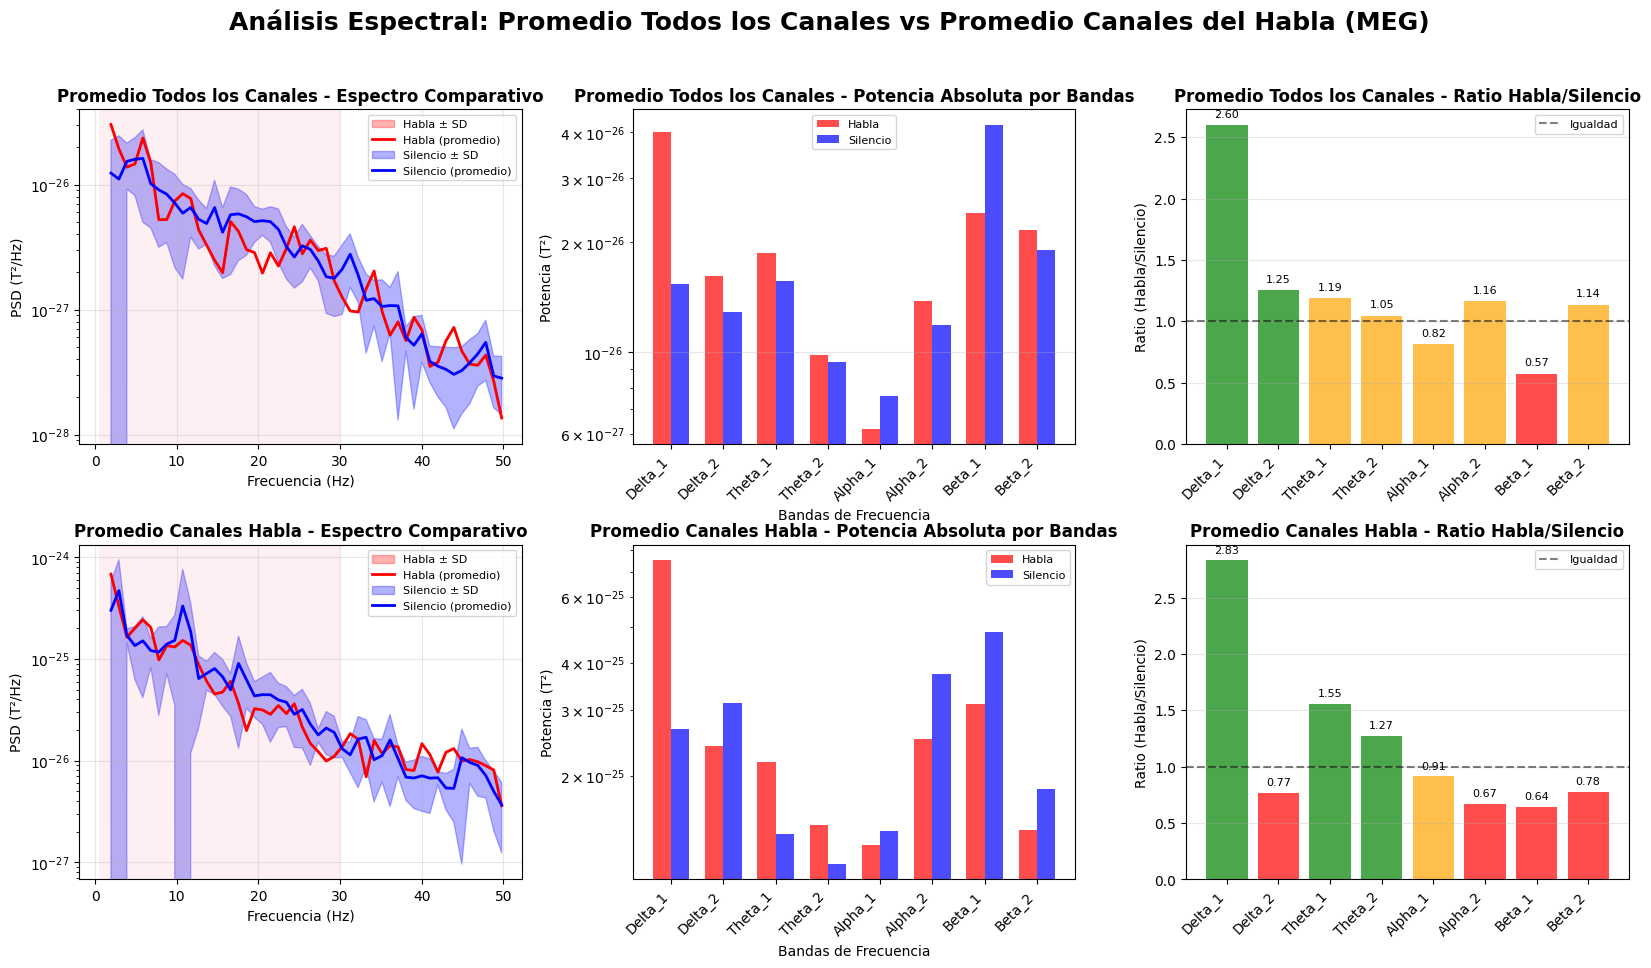

N canales de habla: 23 / N canales totales: 306


In [ ]:
# === VISUALIZACIÓN: PROMEDIO TODOS LOS CANALES vs PROMEDIO CANALES DEL HABLA ===

# Definir máscara de canales de control (puedes ajustar estos índices según tu dataset)
SENSORS_CONTROL_MASK = [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]

# Seleccionar nombres de canales disponibles en el DataFrame
meg_cols = [col for col in unified_df.columns if col.startswith('MEG_ch_')]

# Canales de habla
speech_channels = []
for idx in SENSORS_SPEECH_MASK:
    ch = f'MEG_ch_{idx:03d}'
    if ch in meg_cols:
        speech_channels.append(ch)
# Si no hay suficientes canales de habla, usar los primeros disponibles
if len(speech_channels) < 1:
    speech_channels = meg_cols[:2]

# Calcular promedio de todos los canales y de los canales de habla
all_channels_mean = unified_df[meg_cols].mean(axis=1)
speech_channels_mean = unified_df[speech_channels].mean(axis=1)

sfreq = processed_sfreq
min_duration_samples = int(SPECTRAL_CONFIG['min_segment_duration'] * sfreq)

# Detectar segmentos
tipo_mask = unified_df['kind'].astype(str).str.lower()
habla_mask = tipo_mask.isin(['word', 'phoneme'])
silencio_mask = tipo_mask == 'silence'
def find_continuous_segments(mask, min_duration):
    segments = []
    in_segment = False
    start_idx = 0
    for i, is_active in enumerate(mask):
        if is_active and not in_segment:
            start_idx = i
            in_segment = True
        elif not is_active and in_segment:
            if i - start_idx >= min_duration:
                segments.append((start_idx, i))
            in_segment = False
    if in_segment and len(mask) - start_idx >= min_duration:
        segments.append((start_idx, len(mask)))
    return segments
habla_segments = find_continuous_segments(habla_mask, min_duration_samples)
silencio_segments = find_continuous_segments(silencio_mask, min_duration_samples)
if not habla_segments or not silencio_segments:
    print("❌ No hay suficientes segmentos continuos para el análisis")
else:
    # Dos grupos: promedio de todos los canales y promedio de canales de habla
    group_names = ['Promedio Todos los Canales', 'Promedio Canales Habla']
    group_data = [all_channels_mean, speech_channels_mean]
    fig = plt.figure(figsize=(20, 10))
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 1], hspace=0.3, wspace=0.25)
    for i, (name, data_mean) in enumerate(zip(group_names, group_data)):
        # Procesar segmentos de habla
        habla_psds, habla_freqs, target_length = [], None, None
        for start_idx, end_idx in habla_segments[:5]:
            segment_data = data_mean.iloc[start_idx:end_idx].values
            if len(segment_data) >= min_duration_samples:
                try:
                    freqs, psd = calculate_power_spectral_density(
                        segment_data, sfreq, method='welch',
                        freq_range=SPECTRAL_CONFIG['freq_range'],
                        nperseg=SPECTRAL_CONFIG['nperseg_short']
                    )
                    if target_length is None:
                        target_length = len(psd)
                        habla_freqs = freqs
                    elif len(psd) != target_length:
                        from scipy.interpolate import interp1d
                        interp_func = interp1d(freqs, psd, kind='linear', bounds_error=False, fill_value=0)
                        psd = interp_func(habla_freqs)
                    habla_psds.append(psd)
                except Exception as e:
                    continue
        # Procesar segmentos de silencio
        silencio_psds, silencio_freqs = [], None
        for start_idx, end_idx in silencio_segments[:5]:
            segment_data = data_mean.iloc[start_idx:end_idx].values
            if len(segment_data) >= min_duration_samples:
                try:
                    freqs, psd = calculate_power_spectral_density(
                        segment_data, sfreq, method='welch',
                        freq_range=SPECTRAL_CONFIG['freq_range'],
                        nperseg=SPECTRAL_CONFIG['nperseg_short']
                    )
                    if habla_freqs is not None and len(psd) != len(habla_freqs):
                        from scipy.interpolate import interp1d
                        interp_func = interp1d(freqs, psd, kind='linear', bounds_error=False, fill_value=0)
                        psd = interp_func(habla_freqs)
                        freqs = habla_freqs
                    silencio_psds.append(psd)
                    if silencio_freqs is None:
                        silencio_freqs = freqs
                except Exception as e:
                    continue
        if not habla_psds or not silencio_psds:
            continue
        try:
            habla_psds_array = np.array(habla_psds)
            silencio_psds_array = np.array(silencio_psds)
            avg_psd_habla = np.mean(habla_psds_array, axis=0)
            avg_psd_silencio = np.mean(silencio_psds_array, axis=0)
            std_psd_habla = np.std(habla_psds_array, axis=0)
            std_psd_silencio = np.std(silencio_psds_array, axis=0)
        except Exception as e:
            continue
        # Gráfica 1: Espectro comparativo
        ax1 = fig.add_subplot(gs[i, 0])
        freq_mask = (habla_freqs >= SPECTRAL_CONFIG['freq_range_focus'][0]) & (habla_freqs <= SPECTRAL_CONFIG['freq_range_focus'][1])
        ax1.fill_between(habla_freqs[freq_mask], (avg_psd_habla - std_psd_habla)[freq_mask], (avg_psd_habla + std_psd_habla)[freq_mask], alpha=0.3, color='red', label='Habla ± SD')
        ax1.plot(habla_freqs[freq_mask], avg_psd_habla[freq_mask], 'r-', linewidth=2, label='Habla (promedio)')
        ax1.fill_between(silencio_freqs[freq_mask], (avg_psd_silencio - std_psd_silencio)[freq_mask], (avg_psd_silencio + std_psd_silencio)[freq_mask], alpha=0.3, color='blue', label='Silencio ± SD')
        ax1.plot(silencio_freqs[freq_mask], avg_psd_silencio[freq_mask], 'b-', linewidth=2, label='Silencio (promedio)')
        ax1.set_yscale('log')
        ax1.set_title(f'{name} - Espectro Comparativo', fontweight='bold')
        ax1.set_xlabel('Frecuencia (Hz)')
        ax1.set_ylabel('PSD (T²/Hz)')
        ax1.grid(True, alpha=0.3)
        ax1.legend(fontsize=8)
        
        # Marcar bandas de frecuencia
        for band_name, (f_low, f_high) in SPECTRAL_CONFIG['freq_bands'].items():
            if f_high <= SPECTRAL_CONFIG['freq_range_focus'][1]:
                ax1.axvspan(f_low, f_high, alpha=0.1, label=band_name if i == 0 else "")
        
        # Gráfica 2: Potencias por banda
        ax2 = fig.add_subplot(gs[i, 1])
        band_names = list(SPECTRAL_CONFIG['freq_bands'].keys())
        habla_powers, silencio_powers = [], []
        for band_name, band_range in SPECTRAL_CONFIG['freq_bands'].items():
            power_h = calculate_band_power(habla_freqs, avg_psd_habla, band_range)
            power_s = calculate_band_power(silencio_freqs, avg_psd_silencio, band_range)
            habla_powers.append(power_h)
            silencio_powers.append(power_s)
        x_pos = np.arange(len(band_names))
        width = 0.35
        ax2.bar(x_pos - width/2, habla_powers, width, label='Habla', color='red', alpha=0.7)
        ax2.bar(x_pos + width/2, silencio_powers, width, label='Silencio', color='blue', alpha=0.7)
        ax2.set_title(f'{name} - Potencia Absoluta por Bandas', fontweight='bold')
        ax2.set_xlabel('Bandas de Frecuencia')
        ax2.set_ylabel('Potencia (T²)')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(band_names, rotation=45, ha='right')
        ax2.set_yscale('log')
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.legend(fontsize=8)
        
        # Gráfica 3: Ratio Habla/Silencio
        ax3 = fig.add_subplot(gs[i, 2])
        
        ratios = [h/s if s > 0 else 0 for h, s in zip(habla_powers, silencio_powers)]
        colors = ['green' if r > 1.2 else 'orange' if r > 0.8 else 'red' for r in ratios]
        
        bars = ax3.bar(band_names, ratios, color=colors, alpha=0.7)
        ax3.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Igualdad')
        ax3.set_title(f'{name} - Ratio Habla/Silencio', fontweight='bold')
        ax3.set_ylabel('Ratio (Habla/Silencio)')
        ax3.set_xticklabels(band_names, rotation=45, ha='right')
        ax3.grid(True, alpha=0.3, axis='y')
        ax3.legend(fontsize=8)
        
        # Añadir valores en las barras
        for bar, ratio in zip(bars, ratios):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{ratio:.2f}', ha='center', va='bottom', fontsize=8)
    plt.suptitle('Análisis Espectral: Promedio Todos los Canales vs Promedio Canales del Habla (MEG)', fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    print(f"N canales de habla: {len(speech_channels)} / N canales totales: {len(meg_cols)}")

In [ ]:
# === TRANSFORMADA DE WAVELET: BANDAS CADA 0.5s PARA TODOS LOS CANALES ===

import pywt

def get_wavelet_band_powers(data, sfreq, bands, window_sec=0.5, wavelet='morl'):
    n_channels = data.shape[1]
    n_samples = data.shape[0]
    window_size = int(window_sec * sfreq)
    n_windows = n_samples // window_size
    results = []
    times = []
    for w in range(n_windows):
        start = w * window_size
        end = start + window_size
        window_data = data[start:end, :]
        # Para cada canal
        band_powers = {}
        for ch in range(n_channels):
            ch_data = window_data[:, ch]
            # Transformada de wavelet continua
            scales = np.arange(1, window_size+1)
            coef, freqs = pywt.cwt(ch_data, scales, wavelet, 1/sfreq)
            for band_name, (fmin, fmax) in bands.items():
                # Seleccionar escalas/frecuencias dentro de la banda
                band_mask = (freqs >= fmin) & (freqs <= fmax)
                if np.any(band_mask):
                    power = np.mean(np.abs(coef[band_mask, :])**2)
                else:
                    power = np.nan
                band_powers[f'{band_name}_ch{ch:03d}'] = power
        results.append(band_powers)
        times.append(start / sfreq)
    return results, times

# Preparar datos
meg_cols = [col for col in unified_df.columns if col.startswith('MEG_ch_')]
data = unified_df[meg_cols].values
sfreq = processed_sfreq
bands = SPECTRAL_CONFIG['freq_bands']

# Calcular potencias por banda y ventana
wavelet_results, times = get_wavelet_band_powers(data, sfreq, bands, window_sec=0.5, wavelet='morl')

# Crear DataFrame
wavelet_df = pd.DataFrame(wavelet_results)
wavelet_df['time'] = times

# Asignar segmento y kind por ventana (toma el valor más frecuente en la ventana)
segmentos = []
kinds = []
window_size = int(0.5 * sfreq)
for w in range(len(times)):
    start = w * window_size
    end = start + window_size
    seg = unified_df['segment'].iloc[start:end].mode()
    kind = unified_df['kind'].iloc[start:end].mode()
    segmentos.append(seg.iloc[0] if not seg.empty else '')
    kinds.append(kind.iloc[0] if not kind.empty else '')
wavelet_df['segment'] = segmentos
wavelet_df['kind'] = kinds

print('DataFrame de potencias por banda y canal (wavelet) generado:')
display(wavelet_df.head())